# Cenário 4: 5 qubits e 1 alvo

- Objetivo: criar e executar um circuito com 5 qubits e múltiplos alvos (por exemplo, os estados $3$, $7$ e $11$), avaliar o impacto de múltiplas soluções sobre a fidelidade e a distribuição das medições, calcular o número ideal de iterações ajustando a fórmula para $k > 1$

Neste cenário, usamos:
- Número de qubits: $n = 5$
- Espaço de busca: $N = 2^n = 32$
- Número de alvos: $M = 3$
- Alvos:
  - $|00011\rangle$
  - $|00111\rangle$
  - $|01011\rangle$

O número ideal de iterações de Grover é:
$$
k \approx \left\lfloor \frac{\pi}{4}\sqrt{\frac{N}{M}} \right\rfloor
$$

## Implementação Automática do Algorimto de Grover

In [7]:
# ============================================================
# GROVER MULTI-ALVO (com ancila) + EXECUÇÃO NO SIMULADOR
# Opção A: manter circuito e AJUSTAR os alvos para o formato do counts
# ============================================================

import math
import time
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# ============================================================
# 0) Definir alvos (formato "humano" MSB->LSB, como você escreve)
# ============================================================
targets_human = ["00011", "00111", "01011"]  # |00011>, |00111>, |01011>

# ------------------------------------------------------------
# IMPORTANTE (Opção A):
# O counts do Qiskit costuma aparecer em ordem invertida (LSB->MSB)
# Então, para ANALISAR e MARCAR no histograma/tabela, usamos:
# ------------------------------------------------------------
targets_counts = [t[::-1] for t in targets_human]  # reverte as strings

# ============================================================
# 1) Parâmetros do cenário
# ============================================================
n = len(targets_human[0])     # qubits de busca
M = len(targets_human)        # número de alvos
N = 2**n                      # espaço de busca
k = int(math.floor((math.pi / 4) * math.sqrt(N / M)))

shots = 1024
seed_simulator = 123
seed_transpiler = 123

anc = n                      # ancila é o último qubit
total_qubits = n + 1

# ============================================================
# 2) Construir o circuito quântico (Grover multi-alvo com ancila)
# ============================================================
qc = QuantumCircuit(total_qubits, n, name="Grover_Multi_Alvo_Ancila")

# 2.1) Preparação do estado inicial
qc.h(range(n))   # superposição uniforme no registrador de busca
qc.x(anc)        # ancila em |1>
qc.h(anc)        # ancila em |-> para phase kickback
qc.barrier()

# 2.2) Oráculo multi-alvo (mantém o comportamento que gera counts invertido)
def apply_oracle_for_target(qc_: QuantumCircuit, target: str):
    """
    Aplica U_f que dá flip na ancila somente quando |x> == |target>.
    Aqui interpretamos target na ordem "humana", mas a leitura do counts
    (e por isso a análise) será feita com target invertido (targets_counts).
    """
    # Mapear |target> -> |111..1| aplicando X onde target tem 0
    for i, bit in enumerate(target):
        if bit == "0":
            qc_.x(i)

    # Flip na ancila se todos os qubits de busca forem 1
    qc_.mcx(list(range(n)), anc)

    # Desfazer mapeamento
    for i, bit in enumerate(target):
        if bit == "0":
            qc_.x(i)

def apply_oracle_multi(qc_: QuantumCircuit):
    for t in targets_human:
        apply_oracle_for_target(qc_, t)

# 2.3) Difusor (somente no registrador de busca)
def apply_diffuser(qc_: QuantumCircuit):
    qc_.h(range(n))
    qc_.x(range(n))

    qc_.h(n - 1)
    qc_.mcx(list(range(n - 1)), n - 1)  # MCZ via H-MCX-H no último qubit de busca
    qc_.h(n - 1)

    qc_.x(range(n))
    qc_.h(range(n))

# 2.4) Iterações de Grover: (oráculo + difusor) repetidas k vezes
for _ in range(k):
    apply_oracle_multi(qc)
    qc.barrier()
    apply_diffuser(qc)
    qc.barrier()

# 2.5) Medição: mede apenas registrador de busca (n bits clássicos)
qc.measure(range(n), range(n))

print(f"\nCircuito Grover multi-alvo (com ancila) | n={n}, N={N}, M={M}, k={k}")
print(f"Alvos (humano):  {[f'|{t}>' for t in targets_human]}")
print(f"Alvos (counts):  {[f'|{t}>' for t in targets_counts]}")
print(qc.draw(output="text", fold=-1))


Circuito Grover multi-alvo (com ancila) | n=5, N=32, M=3, k=2
Alvos (humano):  ['|00011>', '|00111>', '|01011>']
Alvos (counts):  ['|11000>', '|11100>', '|11010>']
     ┌───┐      ░ ┌───┐     ┌───┐┌───┐     ┌───┐┌───┐     ┌───┐ ░ ┌───┐┌───┐          ┌───┐┌───┐      ░ ┌───┐     ┌───┐┌───┐     ┌───┐┌───┐     ┌───┐ ░ ┌───┐┌───┐          ┌───┐┌───┐      ░ ┌─┐            
q_0: ┤ H ├──────░─┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├─░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░─┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├─░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░─┤M├────────────
     ├───┤      ░ ├───┤  │  ├───┤├───┤  │  ├───┤└───┘  │  └───┘ ░ ├───┤├───┤       │  ├───┤├───┤      ░ ├───┤  │  ├───┤├───┤  │  ├───┤└───┘  │  └───┘ ░ ├───┤├───┤       │  ├───┤├───┤      ░ └╥┘┌─┐         
q_1: ┤ H ├──────░─┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├───────■────────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░─┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├───────■────────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░──╫─┤M├─────────
     ├───┤ 

In [8]:
# ============================================================
# 3) Executar o circuito no simulador (Aer)
# ============================================================
backend = AerSimulator()

# 3.1) Transpilation (medir tempo)
t0 = time.perf_counter()
tqc = transpile(
    qc,
    backend=backend,
    optimization_level=1,
    seed_transpiler=seed_transpiler
)
t1 = time.perf_counter()
t_transpile = t1 - t0

# 3.2) Execução (medir tempo)
t2 = time.perf_counter()
job = backend.run(tqc, shots=shots, seed_simulator=seed_simulator)
result = job.result()
t3 = time.perf_counter()
t_run = t3 - t2

# 3.3) Contagens (counts)
counts = result.get_counts()
print(f"\nContagens (counts) obtidas: {counts}")


Contagens (counts) obtidas: {'11000': 341, '11010': 332, '11100': 351}


In [17]:
# ============================================================
# 4) Completar contagens com todos os estados (inclui zeros)
# ============================================================
all_states = [format(i, f"0{n}b") for i in range(2**n)]
full_counts = {state: counts.get(state, 0) for state in all_states}
probabilities = {state: c / shots for state, c in full_counts.items()}

# Probabilidade total de sucesso (soma dos alvos no FORMATO DO counts)
p_success = sum(probabilities[t] for t in targets_counts)

# Estado mais frequente
top_state, top_count = max(full_counts.items(), key=lambda kv: kv[1])

# ============================================================
# 5) Relatório de execução (inclui probs dos alvos)
# ============================================================
print("\n" + "=" * 65)
print("EXECUÇÃO (SIMULADOR) — GROVER MULTI-ALVO")
print("-" * 65)
print(f"n = {n} | N = {N} | M = {M} | k = {k}")
print(f"Alvos (humano): {[f'|{t}>' for t in targets_human]}")
print(f"Alvos (counts): {[f'|{t}>' for t in targets_counts]}")
print("-" * 65)
print(f"Tempo de transpile: {t_transpile:.8f} s")
print(f"Tempo de execução (run): {t_run:.8f} s")
print(f"Tempo total (aprox): {t_transpile + t_run:.8f} s")
print("-" * 65)

print("Probabilidades individuais dos alvos (no formato do counts):")
for th, tc in zip(targets_human, targets_counts):
    print(f"Alvo humano |{th}>  ->  aparece como |{tc}>  =>  {full_counts[tc]}/{shots}  (P={probabilities[tc]:.6f})")

print("-" * 65)
print(f"Probabilidade total de sucesso (∑ P(alvos)): {p_success:.6f}")
print(f"Estado mais frequente: |{top_state}> com {top_count}/{shots} (P={probabilities[top_state]:.6f})")
print("=" * 65)


EXECUÇÃO (SIMULADOR) — GROVER MULTI-ALVO
-----------------------------------------------------------------
n = 5 | N = 32 | M = 3 | k = 2
Alvos (humano): ['|00011>', '|00111>', '|01011>']
Alvos (counts): ['|11000>', '|11100>', '|11010>']
-----------------------------------------------------------------
Tempo de transpile: 0.06672254 s
Tempo de execução (run): 0.00151767 s
Tempo total (aprox): 0.06824021 s
-----------------------------------------------------------------
Probabilidades individuais dos alvos (no formato do counts):
Alvo humano |00011>  ->  aparece como |11000>  =>  341/1024  (P=0.333008)
Alvo humano |00111>  ->  aparece como |11100>  =>  351/1024  (P=0.342773)
Alvo humano |01011>  ->  aparece como |11010>  =>  332/1024  (P=0.324219)
-----------------------------------------------------------------
Probabilidade total de sucesso (∑ P(alvos)): 1.000000
Estado mais frequente: |11100> com 351/1024 (P=0.342773)


In [10]:
# ============================================================
# 6) Tabela completa (destaca alvos no formato do counts)
# ============================================================
print("\nDistribuição completa das medições:")
print("-" * 60)
print(f"{'Estado':>10} | {'Contagem':>12} | {'Probabilidade':>14} | Alvo")
print("-" * 60)

targets_set = set(targets_counts)
for state in all_states:
    count = full_counts[state]
    prob = probabilities[state]
    marker = "<-- ALVO" if state in targets_set else ""
    print(f"|{state}> | {count:6d}/{shots:<5d} | {prob:12.6f} | {marker}")

print("-" * 60)
print(f"Probabilidade total de sucesso (∑ P(alvos)): {p_success:.6f}")


Distribuição completa das medições:
------------------------------------------------------------
    Estado |     Contagem |  Probabilidade | Alvo
------------------------------------------------------------
|00000> |      0/1024  |     0.000000 | 
|00001> |      0/1024  |     0.000000 | 
|00010> |      0/1024  |     0.000000 | 
|00011> |      0/1024  |     0.000000 | 
|00100> |      0/1024  |     0.000000 | 
|00101> |      0/1024  |     0.000000 | 
|00110> |      0/1024  |     0.000000 | 
|00111> |      0/1024  |     0.000000 | 
|01000> |      0/1024  |     0.000000 | 
|01001> |      0/1024  |     0.000000 | 
|01010> |      0/1024  |     0.000000 | 
|01011> |      0/1024  |     0.000000 | 
|01100> |      0/1024  |     0.000000 | 
|01101> |      0/1024  |     0.000000 | 
|01110> |      0/1024  |     0.000000 | 
|01111> |      0/1024  |     0.000000 | 
|10000> |      0/1024  |     0.000000 | 
|10001> |      0/1024  |     0.000000 | 
|10010> |      0/1024  |     0.000000 | 
|10011> |   

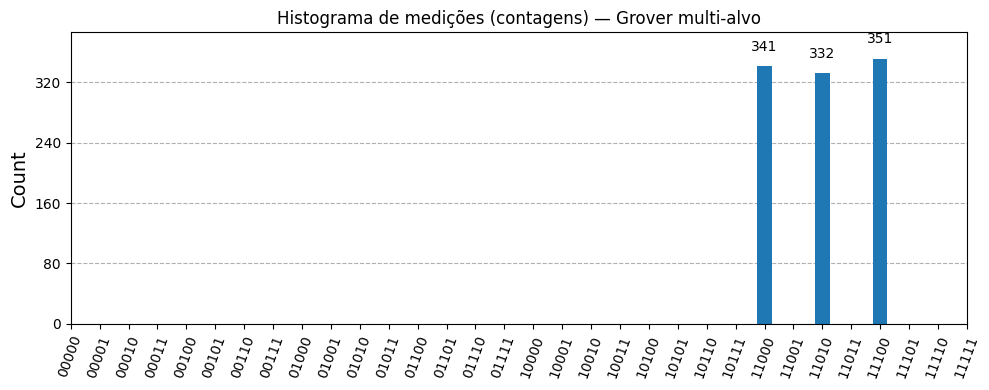

In [19]:
# ============================================================
# 7) Histogramas
# ============================================================
plot_histogram(
    full_counts,
    title="Histograma de medições (contagens) — Grover multi-alvo",
    figsize=(10, 4)
)

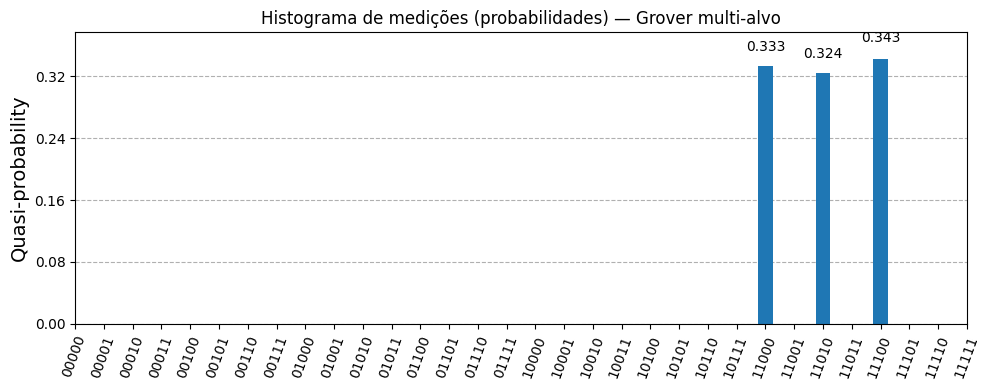

In [18]:
# ============================================================
# 7) Histogramas
# ============================================================

plot_histogram(
    probabilities,
    title="Histograma de medições (probabilidades) — Grover multi-alvo",
    figsize=(10, 4)
)

## Implementação da Busca Linear Clássica

In [20]:
# ============================================================
# BUSCA CLÁSSICA LINEAR (multi-alvo)
# ============================================================

import time

def classical_linear_search_multi(targets: list[str]):
    """
    Realiza busca linear clássica para múltiplos alvos.

    Parameters
    ----------
    targets : list[str]
        Lista de strings binárias (formato humano MSB->LSB),
        ex: ["00011", "00111", "01011"]

    Returns
    -------
    dict
        Resultados da busca clássica contendo:
        - execution_time
        - iterations
        - found_targets (dict: alvo -> índice inteiro)
        - avg_time_per_check
    """
    if not targets:
        raise ValueError("Lista de alvos não pode ser vazia.")

    n = len(targets[0])
    N = 2**n

    # Converter alvos para inteiros (comparação clássica)
    targets_int = {t: int(t, 2) for t in targets}
    targets_set = set(targets_int.values())

    found_targets = {}
    iterations = 0

    t0 = time.perf_counter()

    for x in range(N):
        iterations += 1

        # Simula f(x)
        if x in targets_set:
            # Encontrou um dos alvos
            target_str = format(x, f"0{n}b")
            found_targets[target_str] = x

            # Remove para evitar duplicação
            targets_set.remove(x)

            # Se todos os alvos foram encontrados, pode parar
            if not targets_set:
                break

    t1 = time.perf_counter()

    execution_time = t1 - t0
    avg_time_per_check = execution_time / iterations

    return {
        "n": n,
        "N": N,
        "targets": targets,
        "found_targets": found_targets,
        "iterations": iterations,
        "execution_time": execution_time,
        "avg_time_per_check": avg_time_per_check
    }

In [21]:
# ============================================================
# EXECUÇÃO DA BUSCA CLÁSSICA LINEAR
# ============================================================

classic_result = classical_linear_search_multi(targets_human)

print("\n" + "=" * 65)
print("BUSCA CLÁSSICA LINEAR — MULTI-ALVO")
print("-" * 65)
print(f"n = {classic_result['n']} | N = {classic_result['N']}")
print(f"Alvos: {[f'|{t}>' for t in classic_result['targets']]}")
print("-" * 65)

print("Alvos encontrados:")
for t, idx in classic_result["found_targets"].items():
    print(f"|{t}> encontrado no índice {idx}")

print("-" * 65)
print(f"Número de verificações: {classic_result['iterations']}")
print(f"Tempo total de execução: {classic_result['execution_time']:.8f} s")
print(f"Tempo médio por verificação clássica: {classic_result['avg_time_per_check']:.8e} s")
print("=" * 65)


BUSCA CLÁSSICA LINEAR — MULTI-ALVO
-----------------------------------------------------------------
n = 5 | N = 32
Alvos: ['|00011>', '|00111>', '|01011>']
-----------------------------------------------------------------
Alvos encontrados:
|00011> encontrado no índice 3
|00111> encontrado no índice 7
|01011> encontrado no índice 11
-----------------------------------------------------------------
Número de verificações: 12
Tempo total de execução: 0.00000925 s
Tempo médio por verificação clássica: 7.70833367e-07 s


## Relatório

In [22]:
# ============================================================
# RELATÓRIO DE DESEMPENHO — CLÁSSICO vs QUÂNTICO (GROVER)
# ============================================================

print("\n" + "=" * 75)
print("RELATÓRIO DE DESEMPENHO — BUSCA CLÁSSICA vs GROVER QUÂNTICO")
print("=" * 75)

# ----------------------------
# Informações do problema
# ----------------------------
print("\n[1] CONFIGURAÇÃO DO PROBLEMA")
print("-" * 75)
print(f"Número de qubits (n): {n}")
print(f"Espaço de busca (N = 2^n): {N}")
print(f"Número de alvos (M): {M}")
print(f"Alvos (formato humano): {[f'|{t}>' for t in targets_human]}")
print(f"Alvos (formato counts): {[f'|{t}>' for t in targets_counts]}")
print(f"Número de shots: {shots}")
print(f"Número de iterações de Grover (k): {k}")

# ----------------------------
# Resultados quânticos
# ----------------------------
print("\n[2] RESULTADOS — ALGORITMO QUÂNTICO (GROVER)")
print("-" * 75)
print(f"Tempo de transpile: {t_transpile:.8f} s")
print(f"Tempo de execução (run): {t_run:.8f} s")
print(f"Tempo total aproximado: {t_transpile + t_run:.8f} s")

print("\nProbabilidades dos estados-alvo:")
for th, tc in zip(targets_human, targets_counts):
    print(f"|{th}>  →  |{tc}> : {full_counts[tc]}/{shots}  "
          f"(P = {probabilities[tc]:.6f})")

print(f"\nProbabilidade total de sucesso (∑ P(alvos)): {p_success:.6f}")
print(f"Estado mais frequente: |{top_state}> "
      f"({top_count}/{shots}, P = {probabilities[top_state]:.6f})")

# Custo médio quântico
tq_iter_run = t_run / k
tq_iter_total = (t_transpile + t_run) / k

print("\nCusto médio quântico:")
print(f"- Por iteração de Grover (somente run): {tq_iter_run:.8f} s")
print(f"- Por iteração de Grover (run + transpile): {tq_iter_total:.8f} s")

# ----------------------------
# Resultados clássicos
# ----------------------------
print("\n[3] RESULTADOS — BUSCA CLÁSSICA LINEAR")
print("-" * 75)

print("Alvos encontrados:")
for t, idx in classic_result["found_targets"].items():
    print(f"|{t}> encontrado no índice {idx}")

print(f"\nNúmero total de verificações: {classic_result['iterations']}")
print(f"Tempo total de execução: {classic_result['execution_time']:.8f} s")
print(f"Tempo médio por verificação clássica: "
      f"{classic_result['avg_time_per_check']:.8e} s")

# ----------------------------
# Comparação direta de custos
# ----------------------------
print("\n[4] COMPARAÇÃO DE CUSTO COMPUTACIONAL")
print("-" * 75)

tc_check = classic_result["avg_time_per_check"]

ratio_run = tc_check / tq_iter_run
ratio_total = tc_check / tq_iter_total

print("Comparação (custo clássico / custo quântico):")
print(f"- Considerando apenas execução quântica (run): {ratio_run:.6f}")
print(f"- Considerando execução + transpile:           {ratio_total:.6f}")
print("(Obs.: valores > 1 favorecem o algoritmo de Grover)")

# ----------------------------
# Conclusão automática (curta)
# ----------------------------
print("\n[5] OBSERVAÇÃO FINAL")
print("-" * 75)
if ratio_run > 1:
    print("→ O algoritmo de Grover apresentou vantagem de custo médio por operação.")
else:
    print("→ A busca clássica apresentou menor custo médio por operação.")

print("→ Em ambientes simulados, o overhead quântico ainda domina para N pequeno.")
print("=" * 75)


RELATÓRIO DE DESEMPENHO — BUSCA CLÁSSICA vs GROVER QUÂNTICO

[1] CONFIGURAÇÃO DO PROBLEMA
---------------------------------------------------------------------------
Número de qubits (n): 5
Espaço de busca (N = 2^n): 32
Número de alvos (M): 3
Alvos (formato humano): ['|00011>', '|00111>', '|01011>']
Alvos (formato counts): ['|11000>', '|11100>', '|11010>']
Número de shots: 1024
Número de iterações de Grover (k): 2

[2] RESULTADOS — ALGORITMO QUÂNTICO (GROVER)
---------------------------------------------------------------------------
Tempo de transpile: 0.06672254 s
Tempo de execução (run): 0.00151767 s
Tempo total aproximado: 0.06824021 s

Probabilidades dos estados-alvo:
|00011>  →  |11000> : 341/1024  (P = 0.333008)
|00111>  →  |11100> : 351/1024  (P = 0.342773)
|01011>  →  |11010> : 332/1024  (P = 0.324219)

Probabilidade total de sucesso (∑ P(alvos)): 1.000000
Estado mais frequente: |11100> (351/1024, P = 0.342773)

Custo médio quântico:
- Por iteração de Grover (somente run): 0.

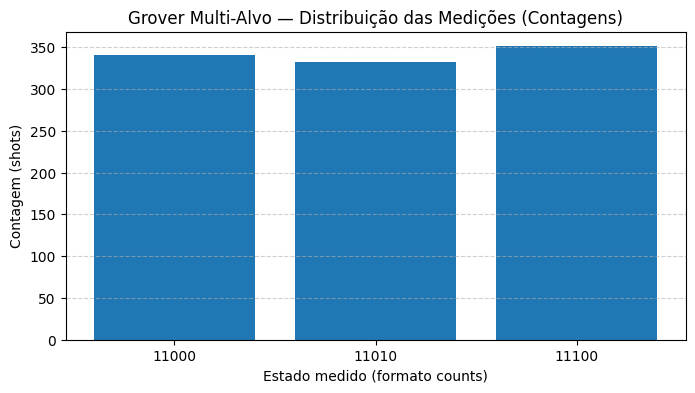

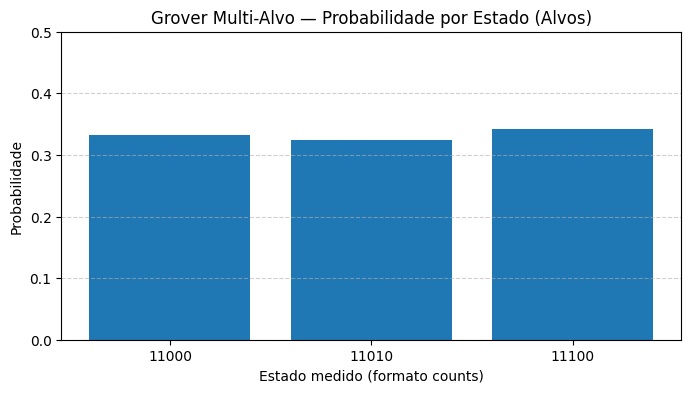

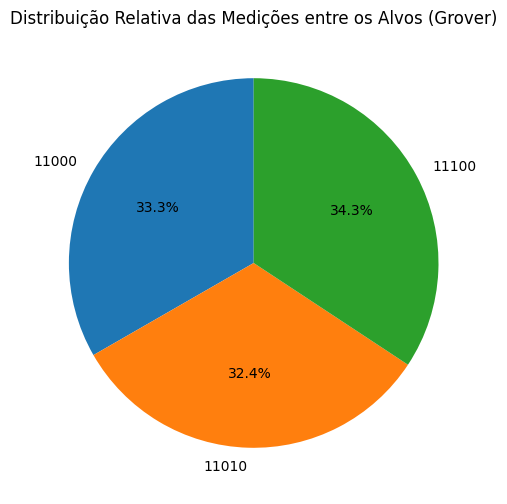

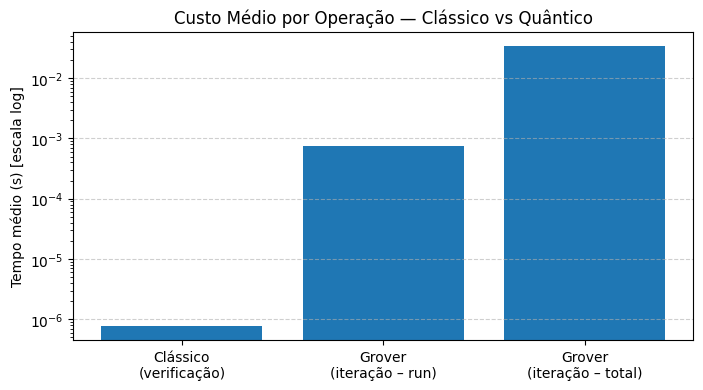

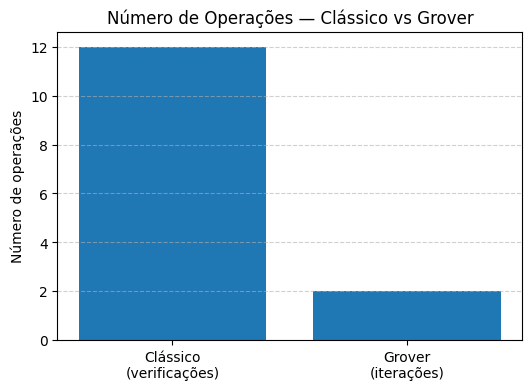

In [27]:
# ============================================================
# GRÁFICOS (usando as VARIÁVEIS já definidas no notebook)
# Espera-se que já existam no ambiente:
# - counts (dict)                 ex: {'11000': 341, '11010': 332, '11100': 351}
# - shots (int)                   ex: 1024
# - targets_human (list[str])     ex: ["00011","00111","01011"]
# - targets_counts (list[str])    ex: ["11000","11100","11010"]
# - k (int), t_run (float), t_transpile (float)
# - classic_result (dict)         com classic_result["avg_time_per_check"], ["iterations"]
# ============================================================

import matplotlib.pyplot as plt

# ----------------------------
# 1) Histograma quântico (contagens) — estados relevantes
# ----------------------------
states = list(counts.keys())
values = [counts[s] for s in states]

plt.figure(figsize=(8, 4))
plt.bar(states, values)
plt.ylabel("Contagem (shots)")
plt.xlabel("Estado medido (formato counts)")
plt.title("Grover Multi-Alvo — Distribuição das Medições (Contagens)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# ----------------------------
# 2) Histograma quântico (probabilidades) — estados relevantes
# ----------------------------
probabilities_relevant = {s: counts[s] / shots for s in states}

plt.figure(figsize=(8, 4))
plt.bar(probabilities_relevant.keys(), probabilities_relevant.values())
plt.ylabel("Probabilidade")
plt.xlabel("Estado medido (formato counts)")
plt.title("Grover Multi-Alvo — Probabilidade por Estado (Alvos)")
plt.ylim(0, 0.5)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# ----------------------------
# 3) Gráfico de pizza — distribuição relativa entre os alvos
# ----------------------------
plt.figure(figsize=(6, 6))
plt.pie(
    values,
    labels=states,
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Distribuição Relativa das Medições entre os Alvos (Grover)")
plt.show()

# ----------------------------
# 4) Comparação de custo médio por operação (Clássico vs Quântico)
# ----------------------------
# Clássico
tc_check = classic_result["avg_time_per_check"]

# Quântico (Grover): custo médio por iteração
tq_iter_run = t_run / k
tq_iter_total = (t_transpile + t_run) / k

labels_cost = [
    "Clássico\n(verificação)",
    "Grover\n(iteração – run)",
    "Grover\n(iteração – total)"
]
values_cost = [tc_check, tq_iter_run, tq_iter_total]

plt.figure(figsize=(8, 4))
plt.bar(labels_cost, values_cost)
plt.yscale("log")
plt.ylabel("Tempo médio (s) [escala log]")
plt.title("Custo Médio por Operação — Clássico vs Quântico")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# ----------------------------
# 5) Comparação: número de operações (conceitual)
# ----------------------------
labels_ops = [
    "Clássico\n(verificações)",
    "Grover\n(iterações)"
]
values_ops = [
    classic_result["iterations"],
    k
]

plt.figure(figsize=(6, 4))
plt.bar(labels_ops, values_ops)
plt.ylabel("Número de operações")
plt.title("Número de Operações — Clássico vs Grover")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

## Discussão

Os resultados obtidos no Cenário 4 evidenciam o comportamento esperado do algoritmo de Grover em um contexto com múltiplos alvos. Considerando um espaço de busca de tamanho $N = 32$ (com $n = 5$ qubits) e $M = 3$ estados solução, a aplicação de $k = 2$ iterações de Grover foi suficiente para concentrar praticamente toda a probabilidade de medição exclusivamente nos estados-alvo. A probabilidade total de sucesso observada foi igual a $1.0$, indicando que todas as medições retornaram estados pertencentes ao conjunto de soluções.

A distribuição das probabilidades entre os três alvos mostrou-se aproximadamente uniforme, com valores próximos de $1/M$, conforme previsto teoricamente para o algoritmo de Grover com múltiplas soluções. Os estados correspondentes aos alvos apresentaram probabilidades de aproximadamente $0{,}33$ cada, enquanto todos os demais estados do espaço de busca tiveram probabilidade nula. Esse resultado confirma que o oráculo multi-alvo e o operador de difusão foram implementados corretamente, promovendo a amplificação seletiva apenas dos estados solução e suprimindo completamente os demais.

Do ponto de vista computacional, observa-se que o custo em tempo do algoritmo quântico, mesmo em um cenário de pequena escala, é significativamente maior do que o da busca clássica linear quando executado em ambiente simulado. O tempo total aproximado da execução quântica foi de cerca de $0{,}068\ \text{s}$, enquanto a busca clássica encontrou todos os alvos em aproximadamente $9{,}25 \times 10^{-6}\ \text{s}$, após apenas 12 verificações. Essa diferença decorre principalmente do overhead associado à computação quântica em simuladores clássicos, incluindo as etapas de transpilation e a simulação explícita da dinâmica quântica.

Entretanto, a análise do número de operações revela a principal vantagem conceitual do algoritmo de Grover. Enquanto a busca clássica requer, no pior caso, um número de verificações proporcional a $N$, o algoritmo quântico utiliza apenas $O(\sqrt{N/M})$ iterações, reduzindo significativamente o número de consultas ao oráculo. No cenário analisado, o Grover necessitou de apenas duas iterações para alcançar sucesso total, contrastando com as 12 verificações realizadas pela busca clássica até encontrar todos os alvos.

Assim, embora a busca clássica apresente melhor desempenho temporal absoluto neste experimento específico, os resultados confirmam a vantagem assintótica do algoritmo de Grover em termos de complexidade algorítmica. Esses achados reforçam que **o real potencial do algoritmo quântico emerge apenas em espaços de busca significativamente maiores e, sobretudo, em hardware quântico real**, onde o custo por iteração não seja dominado pela simulação clássica. Dessa forma, o cenário multi-alvo analisado cumpre seu papel ao demonstrar tanto a correção funcional do algoritmo quanto as limitações práticas atuais de sua execução em ambientes simulados.